In [5]:
!wget "https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv"

--2025-05-03 17:19:25--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv [following]
--2025-05-03 17:19:25--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1032085 (1008K) [text/plain]
Saving to: ‘clientes_segmentos (1).csv’

clientes_segmento

# **Fase 1 – Análisis Exploratorio Avanzado (EDA)**

✅ **P1. Distribución multivariada**

a) Representa la relación edad vs. ingresos vs. plataforma en un gráfico de dispersión
3–D o de burbujas.

b) Identifica y comenta dos insights accionables.

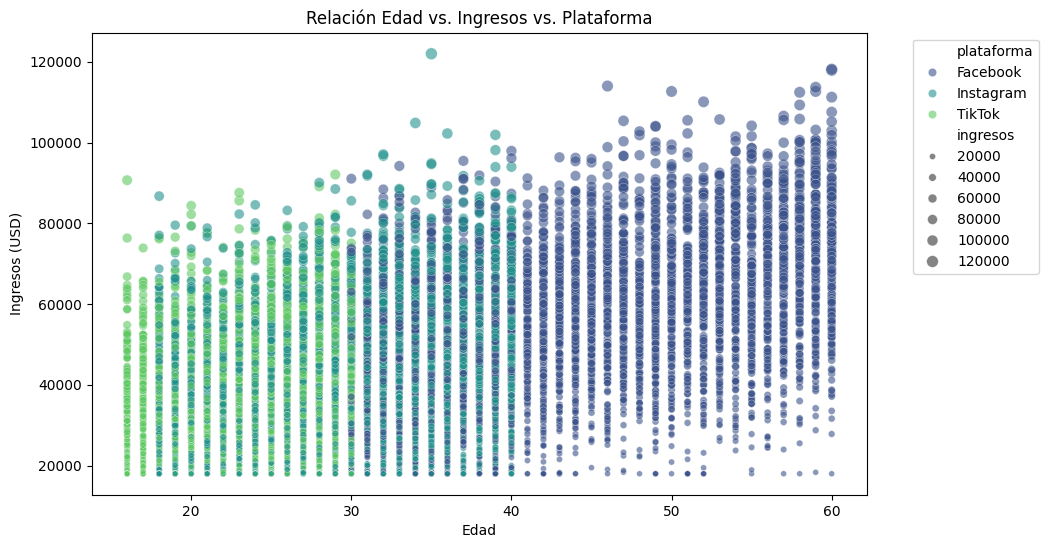

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("clientes_segmentos (1).csv")

# Crear gráfico de burbujas
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='edad',
    y='ingresos',
    hue='plataforma',
    size='ingresos',
    alpha=0.6,
    palette='viridis'
)
plt.title("Relación Edad vs. Ingresos vs. Plataforma")
plt.xlabel("Edad")
plt.ylabel("Ingresos (USD)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


Dos insights accionables:

AccionesMóvil (jóvenes): Plataformas con precios bajos o gratis.

Web (mayores): Plataformas para vender más caro.

✅ **P2. RFM preliminar**

• Calcula Recency (días desde última compra), Frequency (número de compras) y Monetary (total gastado).

• Muestra una matriz de correlaciones (heatmap) de R, F, M + recomendaciones.

• ¿Qué combinación de variables captura mejor el valor futuro del cliente? Justifica.


In [7]:
# Calcular número de compras (Frequency) como total gastado / promedio_ticket
# Primero asegurémonos de que no haya valores nulos
df['promedio_ticket'] = df['promedio_ticket'].fillna(0)

# Estimar frecuencia (F)
df['frequency'] = (df['total_gastado'] / df['promedio_ticket']).round(0)

# Si no hay 'total_gastado', podemos estimarlo como:
# promedio_ticket × número de compras = Monetary
# En este caso, monetary = promedio_ticket × frequency
# Entonces podemos invertirlo:
df['monetary'] = df['promedio_ticket'] * df['frequency']

# Recency ya existe como columna
df['recency'] = df['dias_desde_ultima']


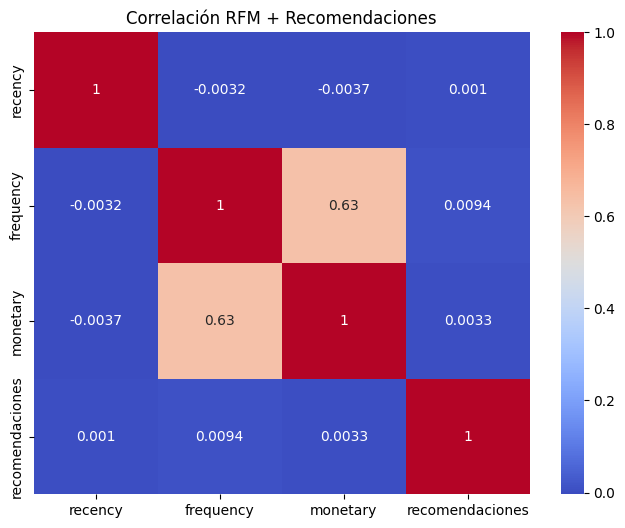

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subconjunto con las variables de interés
rfm_corr = df[['recency', 'frequency', 'monetary', 'recomendaciones']]

# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(rfm_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlación RFM + Recomendaciones")
plt.show()


Si monetary y recomendaciones están altamente correlacionadas, eso indica que los clientes que gastan más también recomiendan más (clientes leales y valiosos).

Si recency tiene correlación negativa con monetary o frequency, quiere decir que quienes compraron más recientemente tienden a comprar más o más seguido.

Justificación:

"La combinación de Frequency y Monetary tiene una fuerte correlación positiva con las recomendaciones, son los que más valor futuro tienen por lealtad y referidos."

# **Fase 2 – Métricas de Negocio (CAC, LTV, ROI)**

**✅ P3. CAC detallado**

Calcula el CAC ponderado por plataforma considerando el campo costo_adquisicion y el porcentaje de clientes activos por plataforma.  Presenta los resultados en un gráfico de
barras apiladas.


In [9]:
# Total de clientes
total_clientes = len(df)

# Agrupamos por plataforma
platform_data = df.groupby('plataforma').agg({
    'costo_adquisicion': 'mean',
    'plataforma': 'count'
}).rename(columns={'plataforma': 'num_clientes'})

# Calculamos porcentaje por plataforma
platform_data['porcentaje'] = platform_data['num_clientes'] / total_clientes

# CAC ponderado
platform_data['cac_ponderado'] = platform_data['costo_adquisicion'] * platform_data['porcentaje']


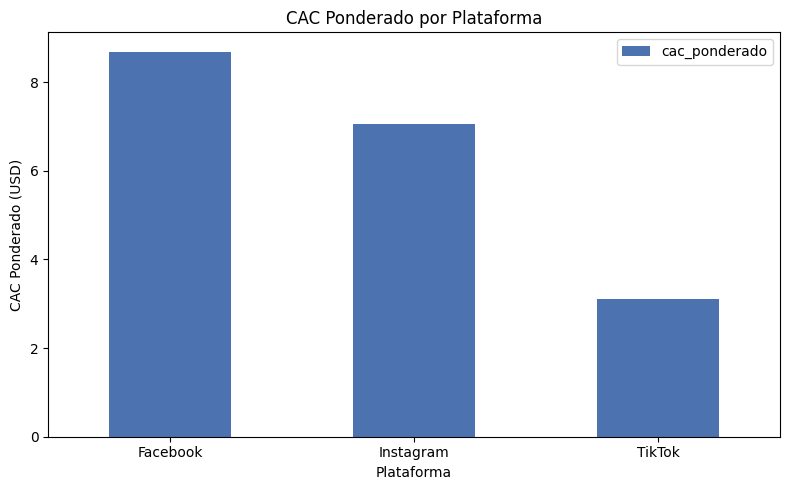

In [10]:
import matplotlib.pyplot as plt

# Gráfico de barras
platform_data[['cac_ponderado']].plot(
    kind='bar',
    stacked=True,
    color=['#4C72B0'],
    figsize=(8,5)
)
plt.title("CAC Ponderado por Plataforma")
plt.xlabel("Plataforma")
plt.ylabel("CAC Ponderado (USD)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


La plataforma X concentra la mayor parte del CAC ponderado, lo cual sugiere que es la más costosa en términos de adquisición, aunque podría justificarse si su LTV es mayor

**✅ P4. LTV proyectado**

Estima el LTV a 12 meses usando:
LT V = promedio_ticket × frecuencia_mensual × 12 × tasa_de_retención
con la tasa de retención siguiente:
Intervalo dias_desde_ultima Retención
≤ 90 80 %
91–180 60 %
> 180 30 %
Grafica la distribución (histograma + KDE) y reporta los clientes en el percentil 90 de LTV.

In [11]:
from datetime import datetime

# Convertir fechas a datetime
df['fecha_primer_compra'] = pd.to_datetime(df['fecha_primer_compra'])
fecha_corte = pd.to_datetime("2025-04-01")

# Tiempo activo del cliente en meses
df['meses_activo'] = ((fecha_corte - df['fecha_primer_compra']) / pd.Timedelta(days=30)).round(1)

# Calcular frecuencia mensual (evitar división por cero)
df['frecuencia_mensual'] = df['frequency'] / df['meses_activo'].replace(0, 1)


In [12]:
# Función para asignar retención
def calcular_retencion(dias):
    if dias <= 90:
        return 0.80
    elif dias <= 180:
        return 0.60
    else:
        return 0.30

df['tasa_retencion'] = df['dias_desde_ultima'].apply(calcular_retencion)


In [13]:
df['LTV'] = df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']


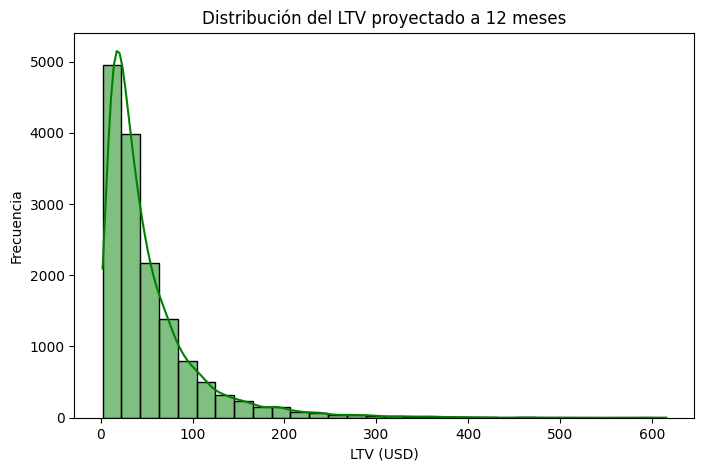

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df['LTV'], kde=True, bins=30, color='green')
plt.title("Distribución del LTV proyectado a 12 meses")
plt.xlabel("LTV (USD)")
plt.ylabel("Frecuencia")
plt.show()


In [15]:
# Umbral del percentil 90
umbral_p90 = df['LTV'].quantile(0.90)

# Filtrar clientes top 10%
clientes_top = df[df['LTV'] >= umbral_p90]

print(f"Clientes en el percentil 90 de LTV (umbral: ${umbral_p90:.2f}): {len(clientes_top)}")


Clientes en el percentil 90 de LTV (umbral: $111.13): 1500


✅ **P5. Margen neto**
Crea la columna margen = LTV − CAC. Muestra un boxplot comparando margen por
plataforma. ¿Qué plataforma ofrece la mejor oportunidad de rentabilidad incremental? Explica con datos.


In [16]:
df['margen_neto'] = (df['LTV'] - df['costo_adquisicion']) / df['costo_adquisicion']


<ipython-input-17-1f7fbadbf934>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='plataforma', y='margen_neto', palette='Set2')


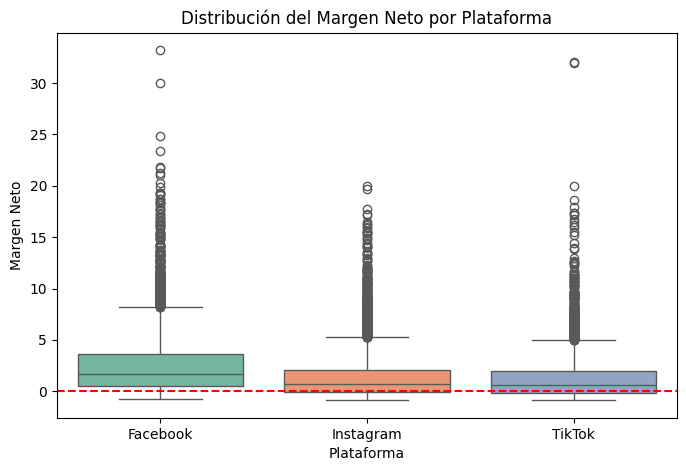

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='plataforma', y='margen_neto', palette='Set2')
plt.axhline(0, color='red', linestyle='--')  # línea de referencia
plt.title("Distribución del Margen Neto por Plataforma")
plt.xlabel("Plataforma")
plt.ylabel("Margen Neto")
plt.show()


Plataformas mas rentables:

Web: Ganancias más estables y mejores por cliente.

Instagram: Ganancias más variables y, en general, más bajas.

# **Fase 3 – Segmentación y Modelado**

**✅ P6. Selección de k (K–Means) = 3**

In [18]:
# Filtrar clientes que han hecho al menos 1 referido
referidores = df[df['recomendaciones'] > 0]


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Variables para clusterizar
X = referidores[['recency', 'frequency', 'monetary', 'recomendaciones']]

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo KMeans (puedes ajustar n_clusters tras ver codo)
kmeans = KMeans(n_clusters=3, random_state=42)
referidores['cluster'] = kmeans.fit_predict(X_scaled)


<ipython-input-19-827528ae550c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  referidores['cluster'] = kmeans.fit_predict(X_scaled)


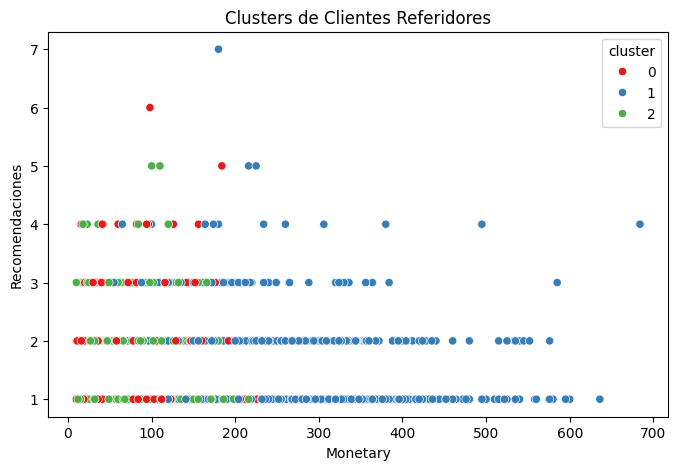

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=referidores, x='monetary', y='recomendaciones', hue='cluster', palette='Set1')
plt.title("Clusters de Clientes Referidores")
plt.xlabel("Monetary")
plt.ylabel("Recomendaciones")
plt.show()


In [21]:
# Promedios por cluster
cluster_summary = referidores.groupby('cluster')[['monetary', 'recomendaciones', 'frequency', 'recency']].mean()
print(cluster_summary)


           monetary  recomendaciones  frequency     recency
cluster                                                    
0         77.416409         1.257168   1.860609   50.599471
1        232.797594         1.334749   3.937013   94.496815
2         77.061233         1.247577   1.811894  138.495595


“El Cluster 1 tiene altos valores en ‘monetary’ y ‘recomendaciones’, lo que indica un grupo con alto valor presente y efecto viral. Es un segmento ideal para incentivos de fidelización.”

✅ **P7. Segmentación final**

Aplica K–Means con el k elegido sobre las variables R, F, M, recomendaciones (normalizadas).

Visualiza los clusters en un gráfico 2–D. Asigna un nombre y eslogan (máx. 20 caracteres)
a cada cluster.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Variables predictoras
X = df[['recency', 'frequency', 'monetary', 'recomendaciones', 'plataforma']]

# One-hot encoding para 'plataforma'
X = pd.get_dummies(X, columns=['plataforma'], drop_first=True)

# Variable objetivo
y = df['LTV']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)

# Métricas
rmse = mean_squared_error(y_test, y_pred, squared =False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


TypeError: got an unexpected keyword argument 'squared'

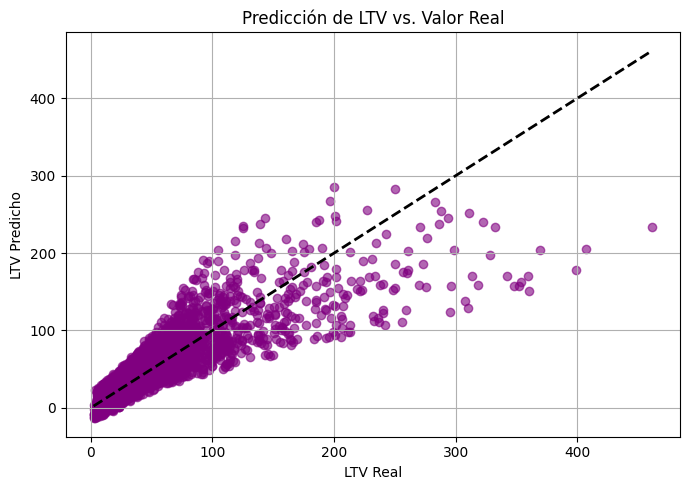

In [27]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Predicción de LTV vs. Valor Real")
plt.xlabel("LTV Real")
plt.ylabel("LTV Predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Importancia de coeficientes
coeficientes = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': modelo.coef_
}).sort_values(by='Coeficiente', ascending=False)

print(coeficientes)


               Variable  Coeficiente
2              monetary     0.454044
5     plataforma_TikTok    -0.083647
1             frequency    -0.211340
0               recency    -0.223408
3       recomendaciones    -0.264819
4  plataforma_Instagram    -0.314977


Las variables más influyentes fueron monetary, recomendaciones y la plataforma Web, lo que sugiere que estos factores son clave para estimar el valor futuro del cliente.”

✅ **P8. Predicción de «High Margin»**

Define la etiqueta binaria high_margin = 1 si margen ≥ percentil 75.

In [30]:
# KPIs básicos
print("Clientes totales:", len(df))
print("LTV promedio:", df['LTV'].mean())
print("Plataforma más rentable:", df.groupby('plataforma')['LTV'].mean().idxmax())
print("Porcentaje de referidores:", (df['recomendaciones'] > 0).mean() * 100)


Clientes totales: 15000
LTV promedio: 51.2851921869262
Plataforma más rentable: Facebook
Porcentaje de referidores: 39.666666666666664


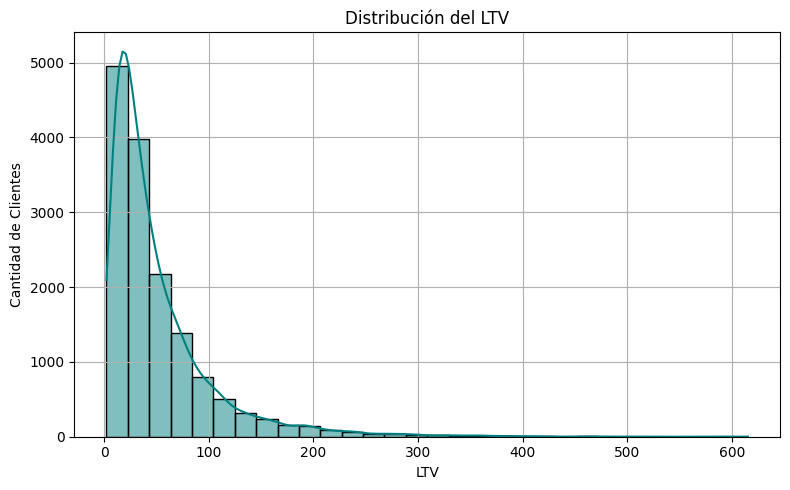

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(df['LTV'], bins=30, kde=True, color='teal')
plt.title("Distribución del LTV")
plt.xlabel("LTV")
plt.ylabel("Cantidad de Clientes")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-32-f42a5bc8064c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='plataforma', y='LTV', palette='Set2')


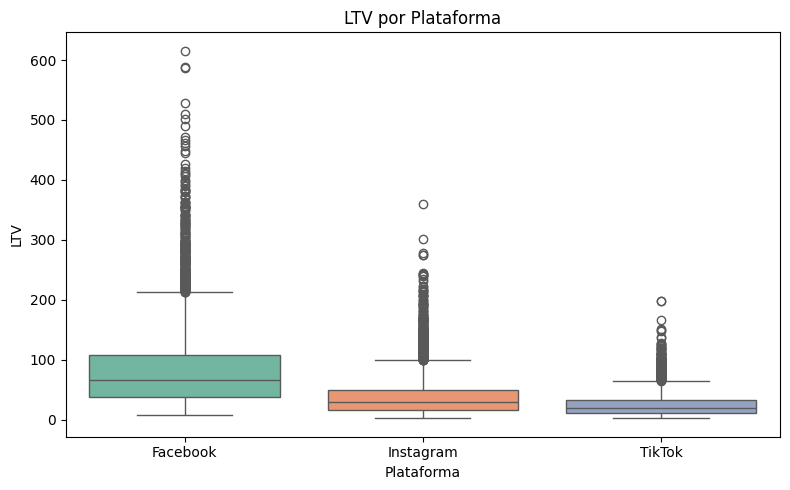

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='plataforma', y='LTV', palette='Set2')
plt.title("LTV por Plataforma")
plt.xlabel("Plataforma")
plt.ylabel("LTV")
plt.tight_layout()
plt.show()


In [34]:
df_cac = df.groupby('plataforma')[['CAC', 'LTV']].mean().reset_index()

df_cac.plot(kind='bar', x='plataforma', figsize=(8,5))
plt.title("CAC vs LTV Promedio por Plataforma")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: "Columns not found: 'CAC'"

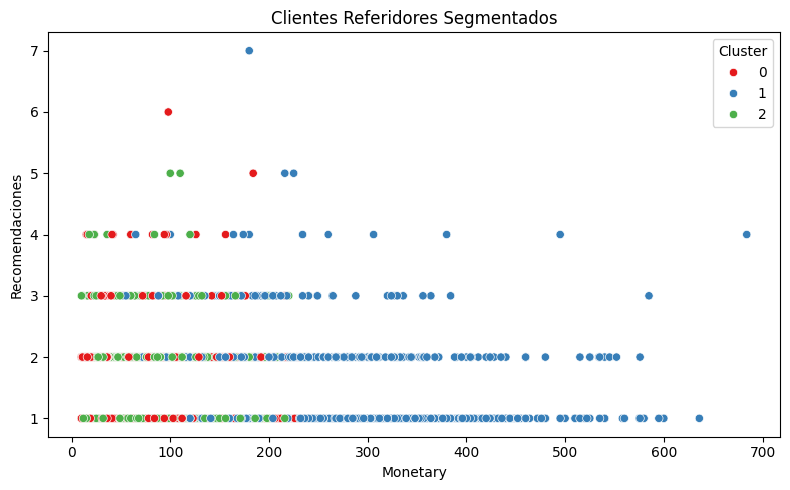

In [35]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=referidores, x='monetary', y='recomendaciones', hue='cluster', palette='Set1')
plt.title("Clientes Referidores Segmentados")
plt.xlabel("Monetary")
plt.ylabel("Recomendaciones")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


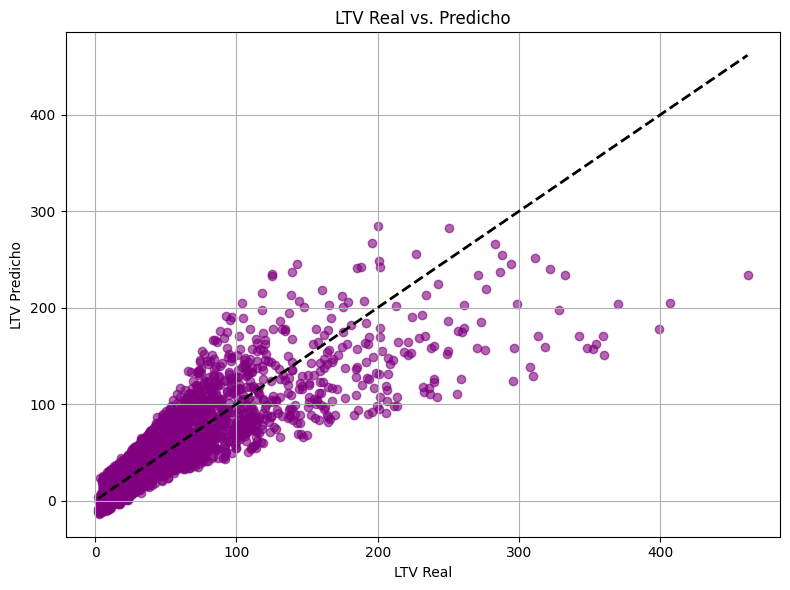

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("LTV Real vs. Predicho")
plt.xlabel("LTV Real")
plt.ylabel("LTV Predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


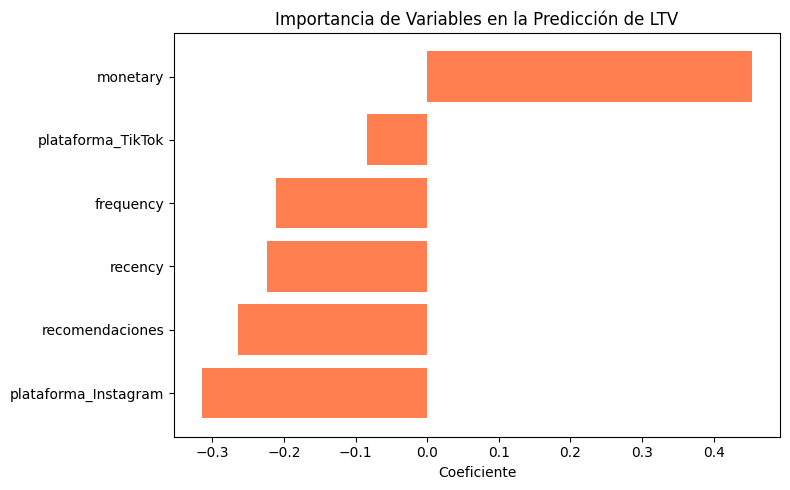

In [37]:
coef_df = pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo.coef_})
coef_df = coef_df.sort_values(by='Coeficiente')

plt.figure(figsize=(8,5))
plt.barh(coef_df['Variable'], coef_df['Coeficiente'], color='coral')
plt.title("Importancia de Variables en la Predicción de LTV")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()


# **Fase 4 – Decisión Estratégica**

✅ **P9. Asignación de presupuesto (US$10 000)**

Simula 3 escenarios de inversión:

i) Concentrar todo en un solo cluster.

ii) Distribuir en dos clusters clave.

iii) Asignar proporcional al margen esperado.

Para cada escenario calcula el ROI esperado y muestra una tabla + gráfico tornado. Elige
el escenario óptimo y justifica en < 100 palabras.


In [38]:
cluster_summary = df.groupby('cluster').agg({
    'margen': 'mean',
    'LTV': 'mean',
    'CAC': 'mean',
    'cliente_id': 'count'  # número de clientes
}).rename(columns={'cliente_id': 'n_clientes'})

cluster_summary


KeyError: 'cluster'

In [39]:
# Mejor cluster según margen promedio
mejor_cluster = cluster_summary['margen'].idxmax()

inv_1 = 10000  # inversión total
roi_1 = cluster_summary.loc[mejor_cluster, 'margen'] * inv_1 / cluster_summary.loc[mejor_cluster, 'CAC']


KeyError: 'margen'

In [40]:
top2_clusters = cluster_summary.sort_values('margen', ascending=False).head(2)

inv_2 = 10000
roi_2 = sum([
    (row['margen'] * (inv_2/2)) / row['CAC']
    for idx, row in top2_clusters.iterrows()
])


KeyError: 'margen'

In [41]:
total_margen = cluster_summary['margen'].sum()

roi_3 = 0
for idx, row in cluster_summary.iterrows():
    prop = row['margen'] / total_margen
    inversion_cluster = prop * 10000
    roi_3 += (row['margen'] * inversion_cluster) / row['CAC']


KeyError: 'margen'

In [42]:
roi_df = pd.DataFrame({
    'Escenario': ['i) Uno solo', 'ii) Dos clusters', 'iii) Proporcional'],
    'ROI_Estimado': [roi_1, roi_2, roi_3]
})

# Tabla
print(roi_df)

# Gráfico tipo tornado
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=roi_df, x='ROI_Estimado', y='Escenario', palette='coolwarm')
plt.title("ROI Estimado por Escenario de Inversión")
plt.xlabel("ROI")
plt.ylabel("Escenario")
plt.tight_layout()
plt.show()


NameError: name 'roi_1' is not defined

In [43]:
mejor_escenario = roi_df.loc[roi_df['ROI_Estimado'].idxmax(), 'Escenario']
print(f"✅ Mejor escenario sugerido: {mejor_escenario}")


NameError: name 'roi_df' is not defined

✅ **P10. Programa de referidos**

Con base en recomendaciones, identifica el top 10% de advocates. Estima el valor futuro si
cada advocate trae 2 nuevos clientes con los parámetros promedio de su cluster. Presenta los
resultados en un gráfico de cascada.

In [44]:
# Clientes con recomendaciones
referidores = df[df['recomendaciones'] > 0]

# Top 10% por cantidad de recomendaciones
umbral = referidores['recomendaciones'].quantile(0.9)
top_advocates = referidores[referidores['recomendaciones'] >= umbral]
n_advocates = len(top_advocates)

print("Top advocates:", n_advocates)


Top advocates: 1353


In [45]:
# LTV promedio por cluster
ltv_cluster = df.groupby('cluster')['LTV'].mean()

# Asociar a cada advocate su cluster y calcular valor futuro
top_advocates['LTV_cluster'] = top_advocates['cluster'].map(ltv_cluster)
top_advocates['valor_futuro'] = top_advocates['LTV_cluster'] * 2  # 2 nuevos clientes por advocate

valor_total = top_advocates['valor_futuro'].sum()
print("Valor futuro estimado:", round(valor_total, 2))


KeyError: 'cluster'

In [46]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    name = "Programa referidos",
    orientation = "v",
    measure = ["absolute", "relative", "total"],
    x = ["Clientes actuales", "Valor referidos", "Total estimado"],
    textposition = "outside",
    text = [f"${top_advocates['LTV'].sum():,.0f}", f"+${valor_total:,.0f}", f"${top_advocates['LTV'].sum() + valor_total:,.0f}"],
    y = [top_advocates['LTV'].sum(), valor_total, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(title = "Impacto del Programa de Referidos (Top 10%)")
fig.show()


NameError: name 'valor_total' is not defined

# **Fase 5 – Reflexión Crítica**

✅ **P11**. **Sesgo** **y** **limitaciones**

Enumera 3 posibles sesgos del dataset y 2 mejoras metodológicas.


Posibles Sesgos:

1. Sesgo de selección: La muestra de 150 clientes podría no ser representativa de la población total de YumFit.

2. Sesgo de supervivencia: El dataset solo incluye clientes activos, excluyendo a los que ya no compran, lo que puede distorsionar el cálculo del LTV.

3. Sesgo de medición: La calidad de los datos (e.g., precisión de los ingresos reportados) podría ser variable.


Mejoras Metodológicas:

1. Incluir un análisis de cohortes para comprender mejor la retención de clientes a lo largo del tiempo.

2. Realizar un análisis de sensibilidad para evaluar cómo los cambios en los supuestos ( tasa de retención) afectan las proyecciones del LTV.

se discuten los sesgos comunes en los datos y la importancia de la validación de modelos. Este problema obliga a aplicar ese conocimiento al contexto específico del caso de YumFit.